In [ ]:
import pandas as pd

# Define column names: 1 unit ID, 1 cycle count, 21 sensor readings = 23 total
col_names = ['unit', 'time'] + [f'sensor_{i}' for i in range(1, 22)]

# Use regex-based separator to handle irregular spaces between columns
df = pd.read_csv('data/train_FD001.txt', sep='\s+', header=None)

# Keep only the first 23 columns, just in case there are extras
df = df.iloc[:, :23]

# Assign column names
df.columns = col_names

# Preview
df.head()



,unit,time,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388


In [ ]:
rul = df.groupby('unit')['time'].max().reset_index()
rul.columns = ['unit', 'max_time']
df = df.merge(rul, on='unit')
df['RUL'] = df['max_time'] - df['time']
df.drop(['max_time'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize features
feature_cols = [col for col in df.columns if col.startswith('sensor')]
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Sequence creation
def gen_sequences(unit_df, seq_length):
    seq_data, labels = [], []
    for i in range(len(unit_df) - seq_length):
        seq = unit_df.iloc[i:i+seq_length][feature_cols].values
        label = unit_df.iloc[i+seq_length]['RUL']
        seq_data.append(seq)
        labels.append(label)
    return np.array(seq_data), np.array(labels)

seq_len = 50
X, y = [], []
for unit in df['unit'].unique():
    unit_df = df[df['unit'] == unit]
    seqs, lbls = gen_sequences(unit_df, seq_len)
    X.extend(seqs)
    y.extend(lbls)

X = np.array(X)
y = np.array(y)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(100, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# Train
model.fit(X, y, epochs=20, batch_size=64, validation_split=0.1)
model.save("models/saved_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          48,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,901 (191.02 KB)

 Trainable params: 48,901 (191.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 8246.7314 - val_loss: 8360.3018
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 5346.9204 - val_loss: 6470.4585
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 4057.3960 - val_loss: 5425.8740
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 3592.9900 - val_loss: 4890.9927
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 3286.9937 - val_loss: 4631.9287
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 3236.0085 - val_loss: 4513.7471
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 3197.5122 - val_loss: 4461.2158
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 3139.6304 - val_loss: 4443.2373
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 3232.7651 - val_loss: 4436.4922
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 3164.9717 - val_loss: 4432.7373
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


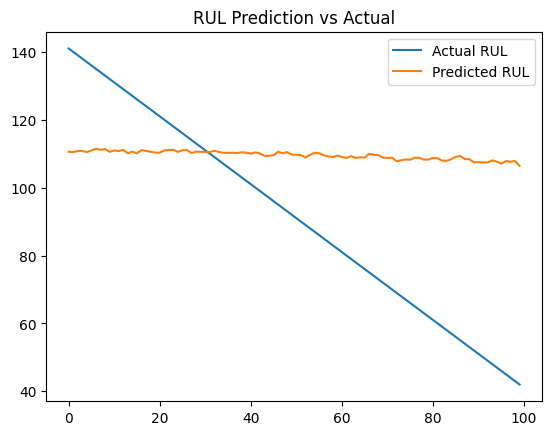

In [ ]:
import matplotlib.pyplot as plt

# Plot sample predictions
y_pred = model.predict(X[:100])
plt.plot(y[:100], label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.legend()
plt.title("RUL Prediction vs Actual")
plt.show()
